# Performing raster and vector operations in Python using pyjeo

**Material provided by Dr. Pieter Kempeneers**

[pyjeo](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/) is the follow up of [PKTOOLS](http://pktools.nongnu.org/html/index.html), a suite of utilities written in C++ for image processing with a focus on remote sensing applications. It is distributed under a General Public License (GPLv3) as a Python package.

The examples in this notebook replicate the exercises on [pktools](http://spatial-ecology.net/docs/build/html/PKTOOLS/pktools_osgeo.html) in order to appreciate the difference and still analogy for those that are familiar with pktools.

In a nutshell, the main differences between pyjeo and pktools from a user's perspective are:

- pyjeo is a Python package should be run in a **Python environment**, whereas pktools applications are run from the command line (e.g., in a bash shell)
- pyjeo runs with images entirely **in memory**, whereas pktools runs most applications line per line. This makes pyjeo considerably faster, but with a larger memory footprint. However, there are some methods implemented in pyjeo to reduce the memory footprint by tiling the image

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Creating masks

**pktools**
We create three masks using different threshold values with [pkgetmask](http://pktools.nongnu.org/html/md_pkgetmask.html)

In [2]:
%%bash
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min  1  -max  2 -data 1 -nodata 0 -ot Byte  -i  geodata/vegetation/ETmean08-11.tif  -o geodata/vegetation/ETmean08-11_01_trhA.tif
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min  5  -max  8 -data 1 -nodata 0 -ot Byte  -i  geodata/vegetation/ETmean08-11.tif  -o geodata/vegetation/ETmean08-11_01_trhB.tif
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min  0  -max  10 -data 0 -nodata 1 -ot Byte  -i  geodata/vegetation/ETmean08-11.tif  -o geodata/vegetation/ETmean08-11_01_trhC.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


**pyjeo**

With pyjeo we create the masks in memory in a "pythonic" way using [get items](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#get-jim-items) without the need to write temporary files.

In [3]:
import pyjeo as pj

In [4]:
fn = Path('geodata/vegetation/ETmean08-11.tif')
jim = pj.Jim(fn)

#get mask
mask1 = (jim>=1) & (jim<=2)
mask2 = (jim>=5) & (jim<=8)
mask3 = (jim<0) | (jim>10)

## Applying masks

**pktools** 

Use the prepared mask and apply to the image with [pksetmask](http://pktools.nongnu.org/html/md_pksetmask.html)

In [5]:
%%bash
pksetmask -co COMPRESS=DEFLATE -co ZLEVEL=9 \
-m geodata/vegetation/ETmean08-11_01_trhA.tif  -msknodata 1 -nodata  -9 \
-m geodata/vegetation/ETmean08-11_01_trhB.tif  -msknodata 1 -nodata  -5 \
-m geodata/vegetation/ETmean08-11_01_trhC.tif  -msknodata 1 -nodata -10 \
-i geodata/vegetation/ETmean08-11.tif -o geodata/vegetation/ETmean08-11_01_msk.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


**pyjeo**

In pyjeo, we can apply the mask in a "pythonic" way using [set items](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#set-jim-items)

In [6]:
jim[mask1] = -9
jim[mask2] = -5
jim[mask3] = -10

However, we can even skip the intermediate step of creating the mask:

In [7]:
jim = pj.Jim(fn)

jim[(jim<0) | (jim>10)] = -10
jim[(jim>=5) & (jim<=8)] = -5
jim[(jim>=1) & (jim<=2)] = -9

The result can then be written on disk if needed:

In [8]:
jim.io.write('geodata/vegetation/ETmean08-11_01_msk_pyjeo.tif', co = ['COMPRESS=DEFLATE', 'ZLEVEL=9'])

## Composite images

**pktools** 

Create a mask to apply during the composite

In [9]:
%%bash
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min 0 -max 25 -data 0 -nodata 1 -ot Byte -i geodata/LST/LST_MOYDmax_month1.tif -o geodata/LST/LST_MOYDmax_month1-msk.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Calculate mean and standard deviation with several images with [pkcomposite](http://pktools.nongnu.org/html/md_pkcomposite.html)

In [10]:
%%bash
pkcomposite $(for file in geodata/LST/LST_MOYDmax_month??.tif geodata/LST/LST_MOYDmax_month?.tif; do echo -i $file; done) \
-m geodata/LST/LST_MOYDmax_month1-msk.tif -msknodata 0 -cr mean   -dstnodata 0 \
-co  COMPRESS=LZW -co ZLEVEL=9 -o geodata/LST/LST_MOYDmax_monthMean.tif

pkcomposite $(for file in geodata/LST/LST_MOYDmax_month?.tif geodata/LST/LST_MOYDmax_month??.tif; do echo -i $file; done) \
-m geodata/LST/LST_MOYDmax_month1-msk.tif -msknodata 0 -cr stdev   -dstnodata -1 \
-co  COMPRESS=LZW -co ZLEVEL=9 -o geodata/LST/LST_MOYDmax_monthStdev.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


An alternative way is to use [pkstatprofile](http://pktools.nongnu.org/html/pkstatprofile.html)

In [11]:
%%bash
# Create a multiband vrt
gdalbuildvrt -overwrite -separate geodata/LST/LST_MOYDmax_month.vrt geodata/LST/LST_MOYDmax_month?.tif geodata/LST/LST_MOYDmax_month??.tif
# Calculate mean and standard deviation
pkstatprofile -co  COMPRESS=LZW -nodata 0 -f mean -f stdev  -i geodata/LST/LST_MOYDmax_month.vrt -o geodata/LST/LST_MOYDmax_month_mean_stdev.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


**pyjeo**

In pyjeo, we can can composite images using [reducePlane](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=reduceplane#geometry._Geometry.reducePlane)

In [12]:
# iterate over files in
# that directory
files1 = sorted(Path('geodata/LST/').glob('LST_MOYDmax_month?.tif'))
files2 = sorted(Path('geodata/LST/').glob('LST_MOYDmax_month??.tif'))

#create single band multi-plane image
mask = None
jim = None
for file in files1:
    if jim is None:
        jim = pj.Jim(file)
        mask = (jim >= 0) & (jim <= 25)
    else:
        jim.geometry.stackPlane(pj.Jim(file))
for file in files2:
    jim.geometry.stackPlane(pj.Jim(file))

jim[mask] = 0
mean = pj.geometry.reducePlane(jim, rule = 'mean', nodata = 0)

/usr/local/lib/python3.8/dist-packages/pyjeo-1.0.8-py3.8.egg/pyjeo/modules/geometry.py:1168: RuntimeWarning: Mean of empty slice


**Briding pyjeo to Numpy**

Pyjeo has been designed to allow for [bridging](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/2_tutorial.html#bridging-jim-to-third-party-packages) Jim raster image objects to third party libraries such as Numpy.

We will re-use the mask Jim object to store the results.

In [13]:
import numpy as np

mask.pixops.convert('GDT_Float32')
jim.np()[jim.np()==0] = np.nan

mask.np()[:] = np.nanmean(jim.np(), axis=0)
mask.geometry.stackBand(mask)
mask.np(1)[:] = np.nanstd(jim.np(), axis=0)

/tmp/ipykernel_114298/2220325774.py:6: RuntimeWarning: Mean of empty slice
  mask.np()[:] = np.nanmean(jim.np(), axis=0)
/home/user/juplab_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


We can avoid NaN in the resulting image by replacing it with 0

In [14]:
mask.np()[:] = np.nan_to_num(np.nanmean(jim.np(), axis=0), nan=0)
mask.np(1)[:] = np.nan_to_num(np.nanstd(jim.np(), axis=0), nan=0)

/tmp/ipykernel_114298/3532211818.py:1: RuntimeWarning: Mean of empty slice
  mask.np()[:] = np.nan_to_num(np.nanmean(jim.np(), axis=0), nan=0)


Even better is to avoid duplication of data to reduce memory footprint

In [15]:
mask.np()[:] = np.nan_to_num(np.nanmean(jim.np(), axis=0), copy = False, nan=0)
mask.geometry.stackBand(mask)
mask.np(1)[:] = np.nan_to_num(np.nanstd(jim.np(), axis=0), copy = False, nan=0)

/tmp/ipykernel_114298/3445497073.py:1: RuntimeWarning: Mean of empty slice
  mask.np()[:] = np.nan_to_num(np.nanmean(jim.np(), axis=0), copy = False, nan=0)


<Figure size 432x288 with 0 Axes>

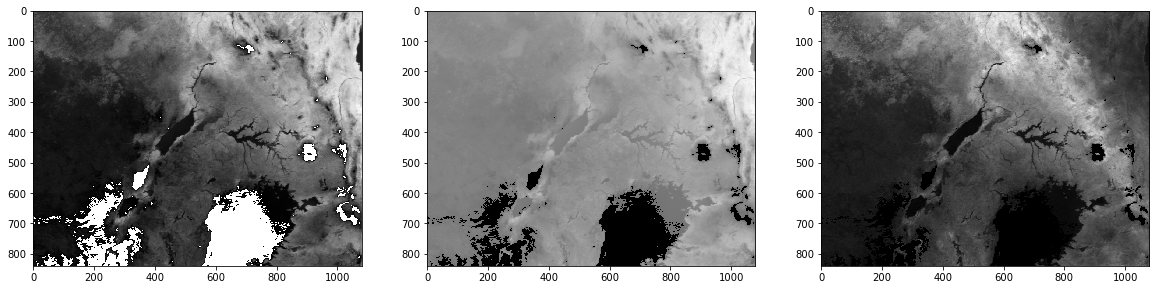

In [16]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side
ax1.imshow(jim.np()[0,:,:])
ax2.imshow(mask.np(0))
ax3.imshow(mask.np(1))
plt.show()

Using tiling mechanism

In [17]:
tiletotal = 4
overlap = 0
def reduceTile(tileindex):
    mask = None
    jim = None
    for file in files1:
        if jim is None:
            jim = pj.Jim(file, tileindex = tileindex, tiletotal = tiletotal, overlap = overlap)
            mask = (jim >= 0) & (jim <= 25)
        else:
            jim1 = pj.Jim(file, tileindex = tileindex, tiletotal = tiletotal, overlap = overlap)
            jim.geometry.stackPlane(jim1)
    for file in files2:
        jim1 = pj.Jim(file, tileindex = tileindex, tiletotal = tiletotal, overlap = overlap)
        jim.geometry.stackPlane(jim1)

    jim[mask] = 0
    return pj.geometry.reducePlane(jim, rule = 'mean', nodata = 0)

<Figure size 432x288 with 0 Axes>

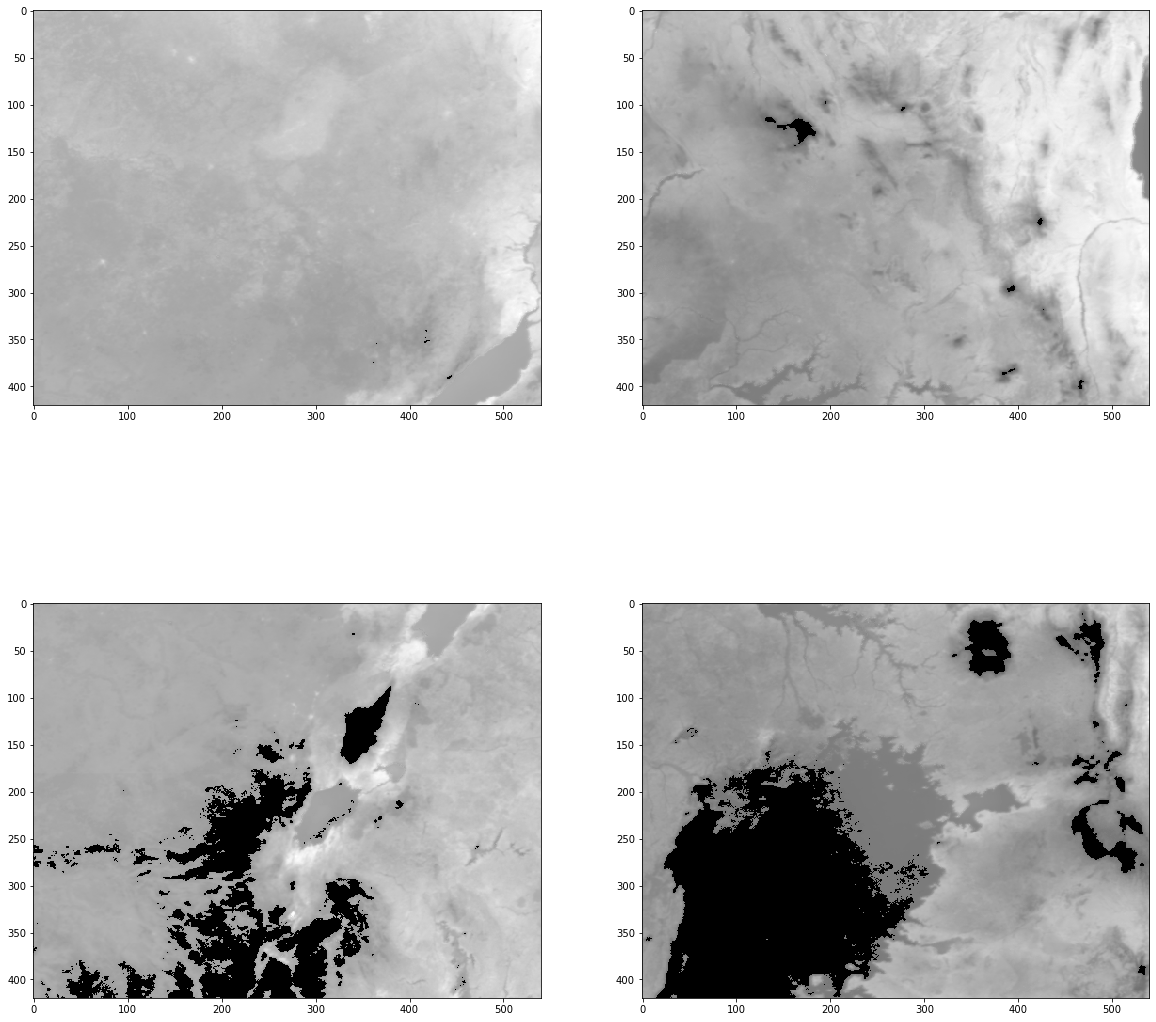

In [18]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax = []
ax.append(fig.add_subplot(221))
ax.append(fig.add_subplot(222))
ax.append(fig.add_subplot(223))
ax.append(fig.add_subplot(224))

for tileindex in range(4):
    ax[tileindex].imshow(reduceTile(tileindex).np())
plt.show()

## Filter images

**pktools** 

Aggregating and filtering images using [pkfilter](http://pktools.nongnu.org/html/pkfilter.html)

In [19]:
%%bash
# mean aggregation 
pkfilter -co COMPRESS=DEFLATE -co ZLEVEL=9 -nodata 0 -ot Float32 -dx 10 -dy 10 -f mean -d 10 -i geodata/LST/LST_MOYDmax_monthMean.tif -o geodata/LST/LST_MOYDmax_monthMean_aggreate10mean.tif
# mean circular moving window
pkfilter -co COMPRESS=DEFLATE -co ZLEVEL=9 -nodata 0 -ot Float32 -dx 11 -dy 11 -f mean -circ  -i geodata/LST/LST_MOYDmax_monthMean.tif -o geodata/LST/LST_MOYDmax_monthMean_circular11mean.tif

opening output image geodata/LST/LST_MOYDmax_monthMean_aggreate10mean.tif with 1 bands
0...10...20...30...40...50...60...70...80...90...100 - done.
opening output image geodata/LST/LST_MOYDmax_monthMean_circular11mean.tif with 1 bands
0...10...20...30...40...50...60...70...80...90...100 - done.


**pyjeo**

In pyjeo, we can can use [filter](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=filter2d#ngbops._NgbOps.filter2d) method, but more functions are available via bridging pyjeo to third party libraries such as [scipy]()

In [20]:
import pyjeo as pj
from pathlib import Path
from scipy import ndimage
import numpy as np
fn = Path('geodata/LST/LST_MOYDmax_monthMean.tif')
jim = pj.Jim(fn)
taps = np.ones((10, 10))
mean = pj.ngbops.firfilter2d(jim, taps=taps, norm=True, pad='symmetric')
print(mean.properties.nrOfCol(), mean.properties.nrOfRow())
mean = mean[::10,::10]
print(mean.properties.nrOfCol(), mean.properties.nrOfRow())

1080 840
108 84


<Figure size 432x288 with 0 Axes>

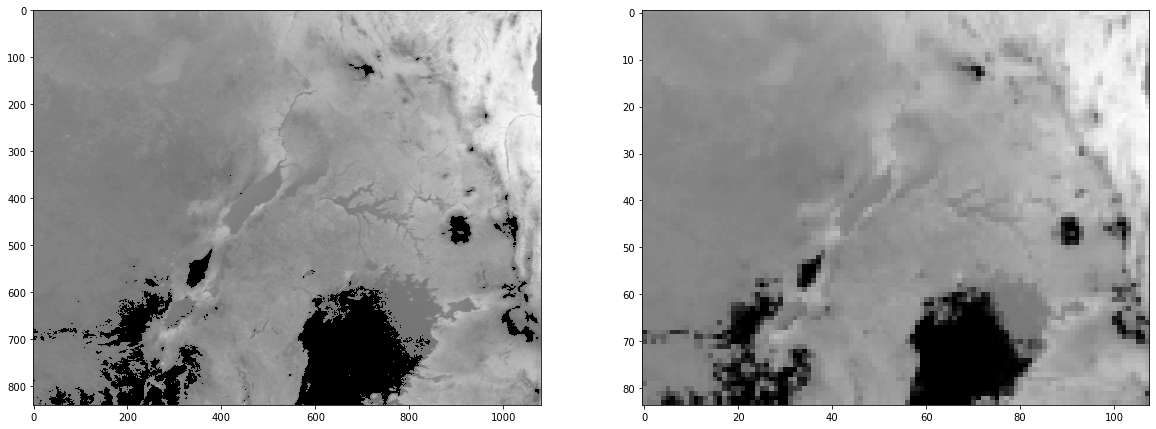

In [21]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(jim.np())
ax2.imshow(mean.np())
plt.show()

In [22]:
def unit_circle(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt(A[:,None] + A)
    return (dists<=r).astype(int)
unit_circle(10)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
mean = pj.ngbops.firfilter2d(jim, taps=unit_circle(10), norm=True, pad='symmetric')

<Figure size 432x288 with 0 Axes>

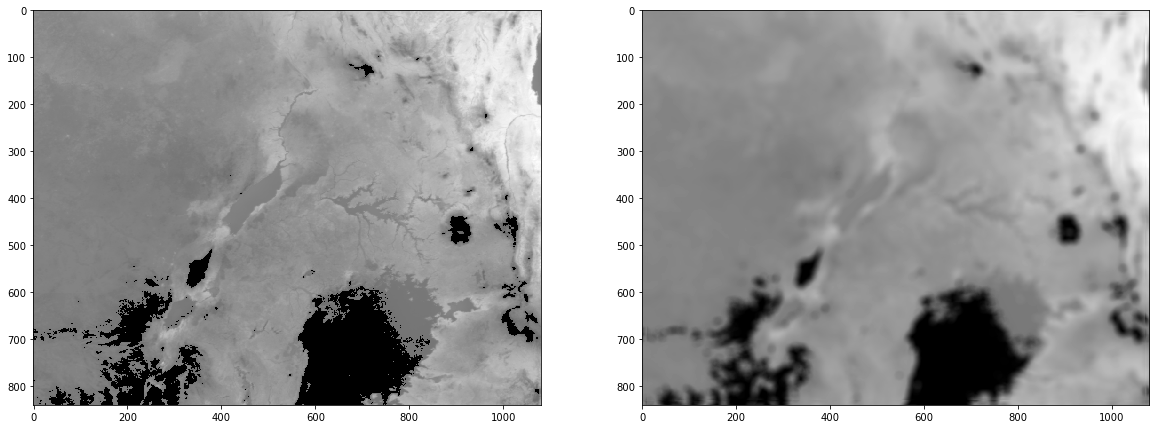

In [24]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(jim.np())
ax2.imshow(mean.np())
plt.show()

More functions are available via bridging pyjeo to third party libraries such as Multidimensional image processing from [scipy](https://docs.scipy.org/doc/scipy/tutorial/ndimage.html)

In [25]:
jim_filtered = pj.Jim(jim)
jim_filtered.np()[:] = ndimage.gaussian_filter(jim.np(), sigma = 2)
ndimage.gaussian_filter(jim.np(), sigma = 2, output=jim.np())
assert jim.properties.isEqual(jim_filtered)

## Images statistics

**pktools** 

Aggregating and filtering images using [pkstat](http://pktools.nongnu.org/html/pkstat.html)

In [26]:
%%bash
pkstat -hist  -src_min 0  -i geodata/temperature/ug_bio_3.tif > geodata/temperature/ug_bio_3.hist
head geodata/temperature/ug_bio_3.hist

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0


In [27]:
%%bash
pkstat -hist  -nbin  20 -src_min 0  -i geodata/vegetation/GPPstdev08-11.tif

0.1055006266 2058
0.3165018797 3246
0.5275031328 25726
0.7385043859 54955
0.9495056391 43453
1.160506892 81369
1.371508145 53690
1.582509398 10960
1.793510652 33823
2.004511905 42521
2.215513158 13744
2.426514411 4183
2.637515664 1539
2.848516917 633
3.05951817 278
3.270519423 202
3.481520677 252
3.69252193 230
3.903523183 33
4.114524436 1


**pyjeo**

In pyjeo, we can can use [getStats](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=getstats#stats._Stats.getStats)

In [28]:
fn = Path('geodata/temperature/ug_bio_3.tif')
jim = pj.Jim(fn)
stats = jim.stats.getStats('histogram', src_min = 0)
print(stats['bin'][0:10])
print(stats['histogram'][0:10])

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [29]:
fn = Path('geodata/vegetation/GPPstdev08-11.tif')
jim = pj.Jim(fn)
stats = jim.stats.getStats('histogram', src_min = 0, nbin = 20)
for index, bin in enumerate(stats['bin']):
    print(bin, stats['histogram'][index])

0.1055006266 2058.0
0.3165018797 3246.0
0.5275031328 25726.0
0.7385043859 54955.0
0.9495056391 43453.0
1.160506892 81369.0
1.371508145 53690.0
1.582509398 10960.0
1.793510652 33823.0
2.004511905 42521.0
2.215513158 13744.0
2.426514411 4183.0
2.637515664 1539.0
2.848516917 633.0
3.05951817 278.0
3.270519423 202.0
3.481520677 252.0
3.69252193 230.0
3.903523183 33.0
4.114524436 1.0


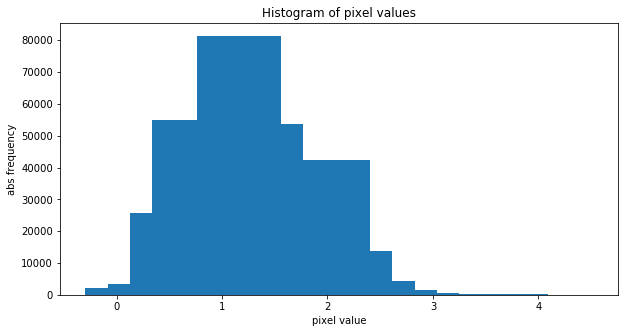

In [30]:
fig = plt.figure(figsize = (10, 5))
plt.bar(stats['bin'],stats['histogram'])
plt.xlabel("pixel value")
plt.ylabel("abs frequency")
plt.title("Histogram of pixel values")
plt.show()

## Images reclassification

**pktools** 

Aggregating and filtering images using [pkreclass](http://pktools.nongnu.org/html/pkreclass.html)

In [31]:
%%bash
pkstat -hist -i geodata/temperature/ug_bio_3.tif | grep -v " 0" | awk '{ if ($1<75) {print $1, 0} else {print $1 , 1}}' > geodata/temperature/reclass_ug_bio_3.txt
pkreclass -co COMPRESS=DEFLATE -co ZLEVEL=9 -code geodata/temperature/reclass_ug_bio_3.txt -i geodata/temperature/ug_bio_3.tif  -o geodata/temperature/reclass_ug_bio_3.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


**pyjeo**

In pyjeo, we can can use [reclass](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=reclass#classify._Classify.reclass)

In [32]:
fn = 'geodata/temperature/ug_bio_3.tif'
jim = pj.Jim(fn)
print(jim.properties.getDataType())
print(jim.stats.getStats())
stats = jim.stats.getStats('histogram')

for index, bin in enumerate(stats['bin']):
    if stats['histogram'][index] > 0:
        print(bin, stats['histogram'][index])

if -9999 in jim.np():
    print("value -9999 is found")
classes0 = [c for c in stats['bin'] if stats['histogram'][stats['bin'].index(c)] > 0 and c < 75]
classes1 = [c for c in stats['bin'] if stats['histogram'][stats['bin'].index(c)] > 0 and c >= 75]
reclasses0 = np.zeros_like(classes0).tolist()
reclasses1 = np.ones_like(classes1).tolist()
print(classes0 + classes1)
print(reclasses0 + reclasses1)

reclass = pj.classify.reclass(jim, classes = classes0 + classes1, reclasses = reclasses0 + reclasses1)

Int32
{'min': -9999.0, 'max': 93.0, 'mean': -1226.4903356481482}
-9999.0 56037.0
61.0 2.0
62.0 9.0
63.0 31.0
64.0 138.0
65.0 235.0
66.0 288.0
67.0 481.0
68.0 589.0
69.0 803.0
70.0 1989.0
71.0 3471.0
72.0 4490.0
73.0 5513.0
74.0 6938.0
75.0 12332.0
76.0 21295.0
77.0 23643.0
78.0 20937.0
79.0 24687.0
80.0 36864.0
81.0 32858.0
82.0 35070.0
83.0 33486.0
84.0 30120.0
85.0 25312.0
86.0 19138.0
87.0 11203.0
88.0 5892.0
89.0 5799.0
90.0 4372.0
91.0 5354.0
92.0 2456.0
93.0 168.0
value -9999 is found
[-9999.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


However, we can do it much simpler:

In [33]:
jim[jim < 75] = 0
jim[jim >= 75] = 1
print(reclass.properties.isEqual(jim))

True


## Zonal statistic (polygon extraction)

**pktools** 

Aggregating and filtering images using [extractogr](http://pktools.nongnu.org/html/pkextractogr.html)

In [34]:
%%bash
rm -f geodata/shp/polygons_stat.*
pkextractogr -srcnodata -339999995214436424907732413799364296704   -r mean -r stdev -r min -i geodata/vegetation/GPPmean08-11.tif -s geodata/shp/polygons.sqlite -o geodata/shp/polygons_stat.sqlite
pkextractogr -f "ESRI Shapefile" -srcnodata -339999995214436424907732413799364296704   -r mean -r stdev -r min -i geodata/vegetation/GPPmean08-11.tif -s geodata/shp/polygons.sqlite -o geodata/shp/polygons_stat.shp

# we can also create a csv that can be manipulate later on with awk
rm  -f geodata/shp/polygons_stat.csv
pkextractogr -f CSV -srcnodata -339999995214436424907732413799364296704   -r mean -r stdev -r min -i geodata/vegetation/GPPmean08-11.tif -s geodata/shp/polygons.sqlite -o geodata/shp/polygons_stat.csv

processing layer polygons
0...10...20...30...40...50...60...70...80...90...100 - done.
processing layer polygons
0...10...20...30...40...50...60...70...80...90...100 - done.
processing layer polygons
0...10...20...30...40...50...60...70...80...90...100 - done.


**Zonal statistic (point extraction)**

In [35]:
%%bash 
# at point location
rm -f geodata/shp/point_stat.csv
pkextractogr -f CSV -srcnodata -339999995214436424907732413799364296704 -r mean -r stdev -r min -i geodata/vegetation/GPPmean08-11.tif -s geodata/shp/presence.shp -o geodata/shp/point_stat.csv
# at point location + 1 pixel around 
rm -f geodata/shp/point-buf_stat.csv
pkextractogr -f CSV -buf 2 -srcnodata -339999995214436424907732413799364296704 -r mean -r stdev -r min -i geodata/vegetation/GPPmean08-11.tif -s geodata/shp/presence.shp -o geodata/shp/point-buf_stat.csv

processing layer presence
0...10...20...30...40...50...60...70...80...90...100 - done.
processing layer presence
0...10...20...30...40...50...60...70...80...90...100 - done.


**pyjeo**

In pyjeo, we can can use [extract](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#geometry._GeometryVect.extract)

output in SQLite format

In [36]:
fn = 'geodata/vegetation/GPPmean08-11.tif'
vfn = 'geodata/shp/polygons.sqlite'
jim = pj.Jim(fn)
jim[jim<0]=-1
print(jim.stats.getStats())
v = pj.JimVect(vfn)
output = 'geodata/shp/temp.sqlite'
Path(output).unlink(missing_ok = True)
extracted1 = pj.geometry.extract(v, jim, rule=['mean', 'stdev', 'min'], output=output, srcnodata = -1)

{'min': -1.0, 'max': 9.73831558227539, 'mean': 2.733609676361084}


output in ESRI Shapefile format

In [37]:
output = 'geodata/shp/temp.shp'
Path(output).unlink(missing_ok = True)
extracted2 = pj.geometry.extract(v, jim, rule=['mean', 'stdev', 'min'], output='geodata/shp/temp.shp', oformat='ESRI Shapefile', srcnodata = -1)

calculate in memory and get result in dictionary

In [38]:
extracted3 = pj.geometry.extract(v, jim, rule=['allpoints'], output='temp1', oformat='Memory', srcnodata = -1)

In pandas format

In [39]:
pd.DataFrame(extracted3.dict())

,label,b0
0,1,2.250272
1,1,2.319497
2,1,2.403872
3,1,2.234919
4,1,2.319769
...,...,...
22143,1,4.432269
22144,1,4.402446
22145,1,4.207745
22146,1,3.909715


Extract point data

In [40]:
vfn = 'geodata/shp/presence.shp'
v = pj.JimVect(vfn)
extracted4 = pj.geometry.extract(v, jim, rule=['mean'], output='point', oformat='Memory', srcnodata = -1)

Extract points with buffer to calculate mean and standard deviation and minimum

In [41]:
buffer = jim.properties.getDeltaX()*1
extracted5 = pj.geometry.extract(v, jim, rule=['mean', 'stdev', 'min'], output='point_buf', oformat='Memory', srcnodata = -1, buffer = buffer)
pd.DataFrame(extracted5.dict())

,FID,meanb0,stdevb0,minb0
0,0,2.432422,0.032791,2.396264
1,1,2.432422,0.032791,2.396264
2,2,2.432422,0.032791,2.396264
3,3,2.418478,0.021126,2.396264
4,4,2.444475,0.027226,2.420856
...,...,...,...,...
150,170,2.295177,0.102342,2.226834
151,171,2.295177,0.102342,2.226834
152,172,2.688564,0.049970,2.636821
153,173,2.688564,0.049970,2.636821


**Remove all the output**

In [42]:
%%bash
rm -f  geodata/vegetation/GPPcv08-11.tif geodata/LST/*_crop.tif geodata/vegetation/ETmean08-11_crop_trh.tif geodata/vegetation/ETmean08-11_crop_trh.txt vegetation/ETmean08-11_crop.txt geodata/vegetation/ETmosaic.vrt geodata/vegetation/ETmosaic.tif geodata/vegetation/stack_??.tifgeodata/vegetation/stack.vrtgeodata/vegetation/tiles.*geodata/vegetation/ETmean08-11_crop_proximity.tifgeodata/vegetation/ETmean08-11_crop_buffer.tif geodata/dem/slope.tifgeodata/dem/aspect.tif geodata/dem/tri.tifgeodata/dem/tpi.tifgeodata/dem/roughness.tifgeodata/vegetation/ETmean08-11_01_trh?.tifgeodata/LST/LST_MOYDmax_month1-msk.tifgeodata/LST/LST_MOYDmax_monthStdev.tifgeodata/LST/LST_MOYDmax_monthMean.tifgeodata/LST/LST_MOYDmax_month_mean_stdev.tifgeodata/LST/LST_MOYDmax_month.vrtgeodata/LST/LST_MOYDmax_monthMean_aggreate10mean.tifgeodata/LST/LST_MOYDmax_monthMean_circular11mean.tif geodata/temperature/reclass_ug_bio_3.tifgeodata/temperature/reclass_ug_bio_3.txtgeodata/shp/polygons_stat.csvgeodata/shp/point-buf_stat.csvgeodata/shp/point_stat.csvgeodata/shp/polygons_stat.*geodata/shp/TM_LARGE_BORDERS.shp.* geodata/shp/TM_UGANDA_BORDERS-0.3.* geodata/vegetation/ETmean08-11_crop.txt geodata/vegetation/ETmean08-11_01_msk_pyjeo.tif geodata/shp/temp.*

rm: cannot remove 'geodata/shp/temp.dbf': Text file busy
rm: cannot remove 'geodata/shp/temp.shp': Text file busy
rm: cannot remove 'geodata/shp/temp.shx': Text file busy
rm: cannot remove 'geodata/shp/temp.sqlite': Text file busy


CalledProcessError: Command 'b'rm -f  geodata/vegetation/GPPcv08-11.tif geodata/LST/*_crop.tif geodata/vegetation/ETmean08-11_crop_trh.tif geodata/vegetation/ETmean08-11_crop_trh.txt vegetation/ETmean08-11_crop.txt geodata/vegetation/ETmosaic.vrt geodata/vegetation/ETmosaic.tif geodata/vegetation/stack_??.tifgeodata/vegetation/stack.vrtgeodata/vegetation/tiles.*geodata/vegetation/ETmean08-11_crop_proximity.tifgeodata/vegetation/ETmean08-11_crop_buffer.tif geodata/dem/slope.tifgeodata/dem/aspect.tif geodata/dem/tri.tifgeodata/dem/tpi.tifgeodata/dem/roughness.tifgeodata/vegetation/ETmean08-11_01_trh?.tifgeodata/LST/LST_MOYDmax_month1-msk.tifgeodata/LST/LST_MOYDmax_monthStdev.tifgeodata/LST/LST_MOYDmax_monthMean.tifgeodata/LST/LST_MOYDmax_month_mean_stdev.tifgeodata/LST/LST_MOYDmax_month.vrtgeodata/LST/LST_MOYDmax_monthMean_aggreate10mean.tifgeodata/LST/LST_MOYDmax_monthMean_circular11mean.tif geodata/temperature/reclass_ug_bio_3.tifgeodata/temperature/reclass_ug_bio_3.txtgeodata/shp/polygons_stat.csvgeodata/shp/point-buf_stat.csvgeodata/shp/point_stat.csvgeodata/shp/polygons_stat.*geodata/shp/TM_LARGE_BORDERS.shp.* geodata/shp/TM_UGANDA_BORDERS-0.3.* geodata/vegetation/ETmean08-11_crop.txt geodata/vegetation/ETmean08-11_01_msk_pyjeo.tif geodata/shp/temp.*\n'' returned non-zero exit status 1.